In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline , Pipeline

In [3]:
def summary_scores(model, train_set_x, test_set_x, train_set_y, test_set_y):
    print(f'Training Accuracy: {model.score(train_set_x, train_set_y)}')
    print(f'Testing Accuracy: {model.score(test_set_x, test_set_y)}')
    print(f'F1 Score: {f1_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Recall: {recall_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Precision: {precision_score(test_set_y, model.predict(test_set_x), average="weighted")}')


#### Load Dataframe

In [4]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')

#### Rename columns for simplicity

In [231]:
df.shape

(9091, 7)

In [5]:
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion', 'tweet_text': 'Tweet'}, inplace= True)

In [6]:
df.drop(9092, inplace=True)
df.reset_index(drop=True, inplace=True)

#### LowerCase tweets for ease of use

In [7]:
df['Text'] = df['Tweet'].str.lower()
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '')
df['Text'] = df['Text'].str.split(' ')

In [8]:
df.dropna(subset=['Text'], inplace=True)

In [9]:
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [10]:
df['test'] = ''
df.fillna('na', inplace=True)

In [11]:
apple_keywords = ['apple', '#apple', 'ipad', '#ipad', '#iphone', 'iphone', 'itunes', '#itunes', 'ios', 'airpods', '#ios', '#airpods'
                 'iphones', 'ipads', 'apples', 'quotapple', 'quotipad', 'ipadquot', 'quotipads', 'ipadsquot', 'applequot', 'quotiphone', 'iphonequot', 'quotios', 'iosquot', 'quotiphones', 'iphonesquot', 'ipad2']
google_keywords = ['google', '#google', 'android', '#android', 'googles', 'androids', 'quotgoogle', 'googlequot', 'quotandroid', 'androidquot', 'quotandroids', 'androidsquot' ]

for ind, val in enumerate(df['Text']):
    if df['Product'].values[ind] == 'na':
        for y in val:
            if y in apple_keywords:
                df['test'].values[ind] = y
            elif y in google_keywords:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['Product'].values[ind]


In [12]:
df['test'] = df['test'].map(lambda x: x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'quotgoogle', 'ipad2', 'googles', 'ipads',
       'applequot', 'ios', 'apples', 'ipadquot',
       'other apple product or service', 'quotipad', 'iosquot',
       'quotiphone', 'androidquot', 'googlequot', 'quotapple', 'androids',
       'iphonequot'], dtype=object)

In [13]:
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads': 'ipad', 'ipad2': 'ipad',
                                'quotgoogle': 'google', 'ipadquot': 'ipad', 'quotipad': 'ipad', 'androidquot': 'android', 'applequot': 'apple',
                               'googlequot': 'google', 'iphonequot': 'iphone', 'quotapple' : 'apple', 'iosquot': 'ios', 'quotiphone': 'iphone',
                                '#ipad' : 'ipad', '#google' : 'google', '#android': 'android', '#apple': 'apple', '#iphone': 'iphone'})
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'ios', 'other apple product or service'],
      dtype=object)

In [14]:
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['Emotion'] = df['Emotion'].map(emotion_dict)

In [15]:
df['Emotion'].value_counts(normalize=True)

Neutral emotion     0.609724
Positive emotion    0.327577
Negative emotion    0.062699
Name: Emotion, dtype: float64

In [16]:
df['test'].value_counts()

ipad                               2286
google                             2087
apple                              1496
iphone                             1052
                                    840
ipad or iphone app                  470
android                             379
other google product or service     293
android app                          81
itunes                               64
other apple product or service       35
ios                                   8
Name: test, dtype: int64

In [17]:
def company_search(test):
    if test == 'iphone':
        return 'apple'
    elif test == 'apple':
        return 'apple'
    elif test == 'ipad':
        return 'apple'
    elif test == 'ipad or iphone app':
        return 'apple'
    elif test == 'itunes':
        return 'apple'
    elif test == 'other apple product or service':
        return 'apple'
    elif test == 'ios':
        return 'apple'
    elif test == 'ipadquot':
        return 'apple'
    elif test == 'applequot':
        return 'apple'
    elif test == 'iphonequot':
        return 'apple'
    elif test == 'quotiphone':
        return 'apple'
    elif test == 'iosquot':
        return 'apple'
    elif test =='quotipad':
        return 'apple'
    elif test == 'quotapple':
        return 'apple'
    elif test =='google':
        return 'google'
    elif test == 'android':
        return 'google'
    elif test == 'other google product or service':
        return 'google'
    elif test == 'android app':
        return 'google'
    elif test == 'quotgoogle':
        return 'google'
    elif test == 'googlequot':
        return 'google'
    elif test == 'androidquot':
        return 'google'
    else:
        return 'unknown'

In [18]:
df['company'] = df['test'].apply(company_search)

In [19]:
df['company'].value_counts()

apple      5411
google     2840
unknown     840
Name: company, dtype: int64

In [126]:
from nltk.tokenize import TweetTokenizer
ttokenize = TweetTokenizer(preserve_case=False, reduce_len=False)

In [132]:
import re

In [133]:
df['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet)
                           for tweet in df['Tweet']]

In [158]:
df['clean_tweet'] = df['Tweet'].str.replace(r'[^\w\s]', '')

In [157]:
def clean_tweet(tweet):
    token = ttokenize.tokenize(tweet)
    tokens = [word.lower() for word in token]
    no_sw = [word for word in tokens if word not in sw]
    lemmad = [lemma.lemmatize(word) for word in no_sw]
    return lemmad
    

In [159]:
df['clean_tweet'] = df['clean_tweet'].apply(clean_tweet)

In [144]:
tokens = list(map(clean_tweet, df['clean_tweet']))

TypeError: 'list' object is not callable

### Add Target values


In [20]:
target_dict = {'Negative emotion': 0, 'Neutral emotion': 1, 'Positive emotion': 2}
df['target'] = df['Emotion'].map(target_dict)

In [21]:
df['target'].value_counts()

1    5543
2    2978
0     570
Name: target, dtype: int64

#### Seperate Dataframes by company

In [22]:
df_apple = df.loc[df['company'] == 'apple']
df_google = df.loc[df['company'] == 'google']


#### Seperate Dataframes by tweet sentiment

In [23]:
df_pos = df.loc[df.target == 2]
df_neg = df.loc[df.target == 0]
df_neutral = df.loc[df.target == 1]

#### Lists/Dictionary of words used in pos/neg/neutral tweets

In [24]:
pos_words = []
neg_words = []
neutral_words = []

for list_ in df_pos['Text']:
    for word in list_:
        pos_words.append(word)

        
for list_ in df_neg['Text']:
    for word in list_:
        neg_words.append(word)
        
        
for list_ in df_neutral['Text']:
    for word in list_:
        neutral_words.append(word)
    

In [25]:
from collections import Counter
sw = stopwords.words('english')

In [26]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [27]:
pos_words = [lemma.lemmatize(word) for word in pos_words if word not in sw]
neg_words = [lemma.lemmatize(word) for word in neg_words if word not in sw]
neutral_words =  [lemma.lemmatize(word) for word in neutral_words if word not in sw]



In [28]:
pos_dict = Counter(pos_words)
neg_dict = Counter(neg_words)
neutral_dict = Counter(neutral_words)

In [29]:
pos_dict = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
neg_dict = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))
neutral_dict = dict(sorted(neutral_dict.items(), key=lambda item: item[1], reverse=True))

In [30]:
pos_dict.pop('')
neg_dict.pop('')
neutral_dict.pop('')

2098

In [31]:
dict(list(pos_dict.items())[0:20])

{'sxsw': 3068,
 'mention': 2113,
 'link': 1206,
 'ipad': 982,
 'rt': 922,
 'apple': 875,
 'google': 690,
 'store': 549,
 'iphone': 520,
 '2': 497,
 'app': 391,
 'new': 359,
 'austin': 292,
 'popup': 218,
 'ipad2': 202,
 'android': 198,
 'amp': 181,
 'get': 181,
 'launch': 174,
 'one': 148}

In [32]:
dict(list(neg_dict.items())[0:20])

{'sxsw': 578,
 'mention': 301,
 'ipad': 181,
 'iphone': 155,
 'google': 141,
 'rt': 137,
 'apple': 106,
 'link': 101,
 '2': 65,
 'app': 60,
 'store': 45,
 'new': 43,
 'like': 42,
 'circle': 36,
 'need': 35,
 'social': 30,
 'apps': 30,
 'people': 29,
 'design': 28,
 'get': 25}

#### Adding common words used in both positive and negative tweets to stopwords list

In [33]:
common_words = ['sxsw', 'mention', 'link', 'ipad', 'iphone', 'google', 'apple', '2', 'android', 'rt']


In [34]:
sw.extend(common_words)

In [48]:
df[]

,Tweet,Product,Emotion,Text,test,company,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",iphone,apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, , awesome, ip...",ipad or iphone app,apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, als...",ipad,apple,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,apple,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,google,2
...,...,...,...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",na,Neutral emotion,"[mention, yup, but, i, dont, have, a, third, a...",android,google,1
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[ipad, everywhere, sxsw, link]",ipad,apple,2
9089,"Wave, buzz... RT @mention We interrupt your re...",na,Neutral emotion,"[wave, buzz, rt, mention, we, interrupt, your,...",google,google,1
9090,"Google's Zeiger, a physician never reported po...",na,Neutral emotion,"[googles, zeiger, a, physician, never, reporte...",google,google,1


## Visualizations

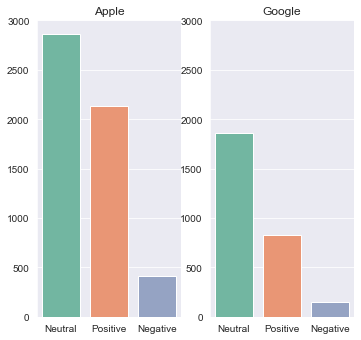

In [396]:
plt.figure(figsize=(15, 12))
ax1 = plt.subplot2grid(shape=(2,5), loc = (0,0))
ax2 = plt.subplot2grid(shape=(2,5), loc = (0,1),)

sns.barplot(x = df_apple['Emotion'].value_counts().index,
           y = df_apple['Emotion'].value_counts().values,
           ax =ax1)
ax1.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax1.set_title('Apple')
ax1.set_ylim(0,3000)

sns.barplot(x = df_google['Emotion'].value_counts().index,
           y = df_google['Emotion'].value_counts().values,
           ax = ax2)
ax2.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax2.set_title('Google')
ax2.set_ylim(0,3000)
ax2.;

<AxesSubplot:>

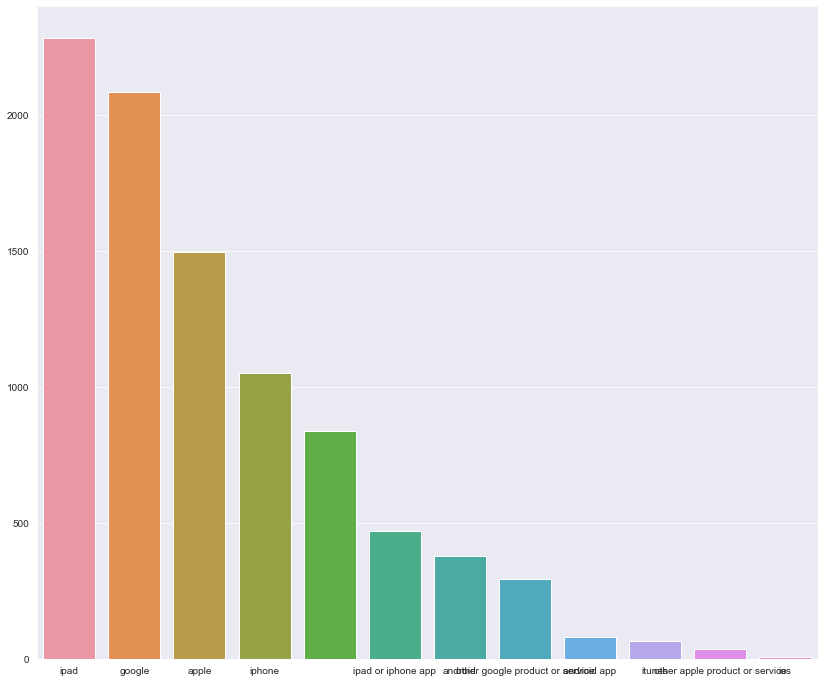

In [47]:
plt.figure(figsize=(14,12))

sns.set_style('darkgrid')

sns.barplot(x = df['test'].value_counts().index,
           y = df['test'].value_counts().values)

<AxesSubplot:>

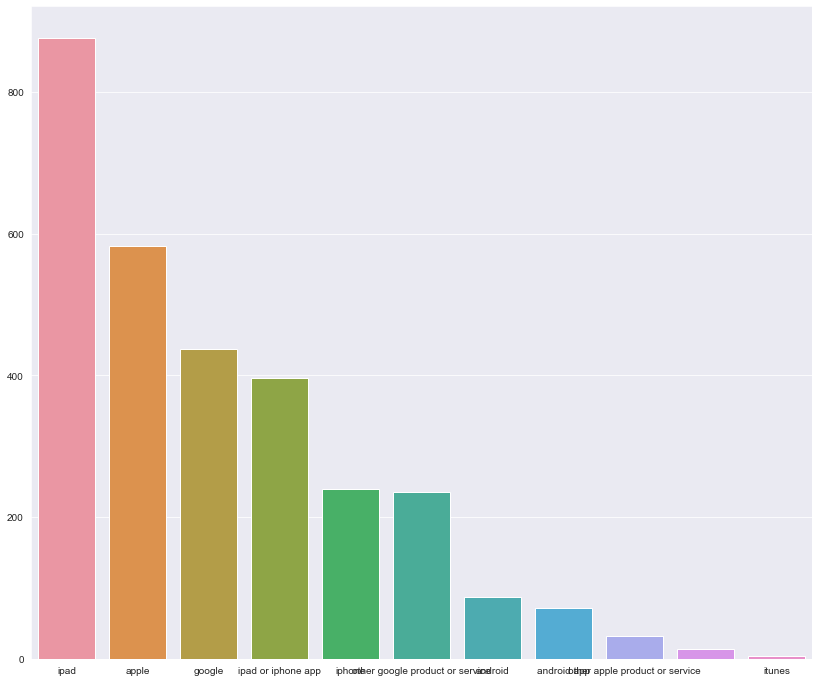

In [133]:
plt.figure(figsize=(14,12))

sns.set_style('darkgrid')

sns.barplot(x = df_pos['test'].value_counts().index,
           y = df_pos['test'].value_counts().values)

<AxesSubplot:>

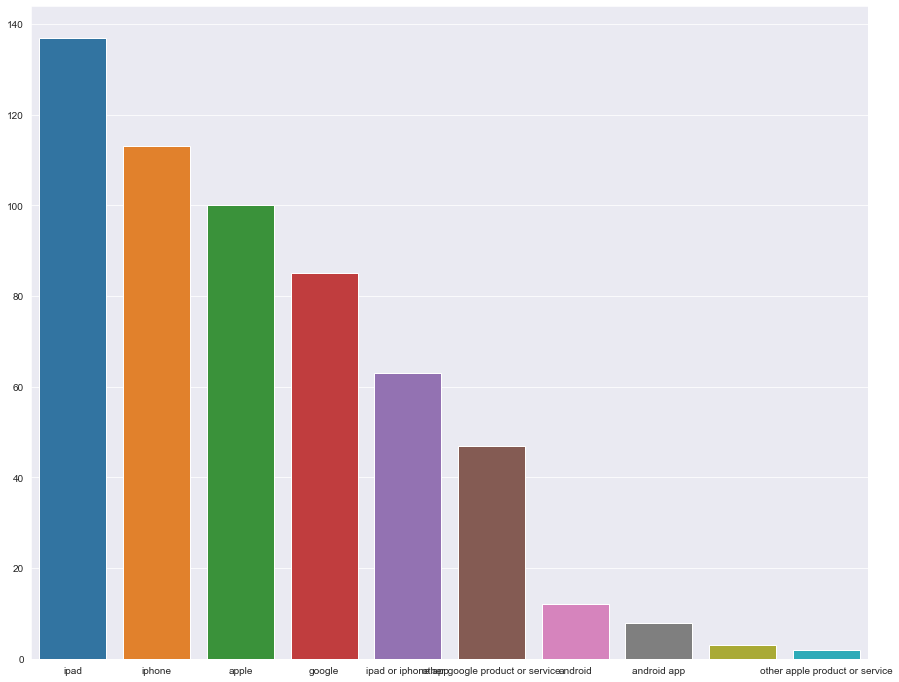

In [134]:
plt.figure(figsize=(15,12))

sns.barplot(x = df_neg['test'].value_counts().index,
           y = df_neg['test'].value_counts().values)

In [73]:
df['test'].value_counts()

ipad                               2286
google                             2087
apple                              1496
iphone                             1052
                                    840
ipad or iphone app                  470
android                             379
other google product or service     293
android app                          81
itunes                               64
other apple product or service       35
ios                                   8
Name: test, dtype: int64

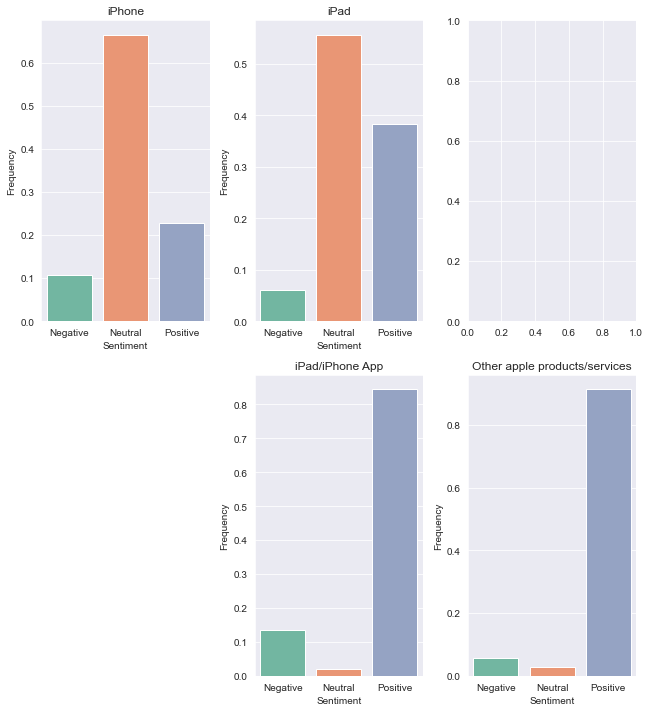

In [390]:
plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))
ax5 = plt.subplot2grid(shape=(2,4), loc=(0,2))

sns.set_palette('Set2')

sns.barplot(x = df.loc[df.test == 'iphone']['target'].value_counts().index,
               y = df.loc[df.test == 'iphone']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('iPhone')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'ipad']['target'].value_counts().index,
           y = df.loc[df.test == 'ipad']['target'].value_counts(normalize=True),
           ax=ax2)


ax2.set_title('iPad')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'ipad or iphone app']['target'].value_counts().index,
           y = df.loc[df.test == 'ipad or iphone app']['target'].value_counts(normalize=True),
           ax=ax3)

ax3.set_title('iPad/iPhone App')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])


sns.barplot(x = df.loc[df.test == 'other apple product or service']['target'].value_counts().index,
           y = df.loc[df.test == 'other apple product or service']['target'].value_counts(normalize=True),
           ax=ax4)

ax4.set_title('Other apple products/services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.tight_layout()



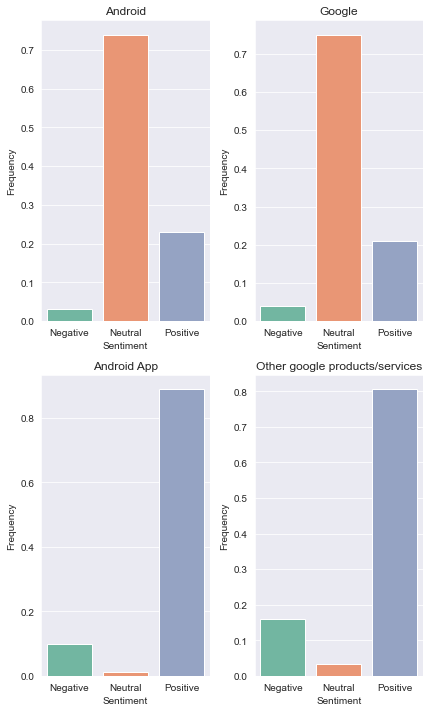

In [121]:
plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))

sns.barplot(x = df.loc[df.test == 'android']['target'].value_counts().index,
               y = df.loc[df.test == 'android']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('Android')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'google']['target'].value_counts().index,
           y = df.loc[df.test == 'google']['target'].value_counts(normalize=True),
           ax=ax2)


ax2.set_title('Google')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'android app']['target'].value_counts().index,
           y = df.loc[df.test == 'android app']['target'].value_counts(normalize=True),
           ax=ax3)

ax3.set_title('Android App')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])


sns.barplot(x = df.loc[df.test == 'other google product or service']['target'].value_counts().index,
           y = df.loc[df.test == 'other google product or service']['target'].value_counts(normalize=True),
           ax=ax4)

ax4.set_title('Other google products/services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.tight_layout()


In [90]:
app = (df.loc[df.test == 'ipad or iphone app']['Text'])

In [100]:
app_words = []

for list in app:
    for word in list:
        app_words.append(word)
        


In [105]:
app_words_c = Counter(app_words)
dict(sorted(app_words_c.items(), key=lambda item: item[1], reverse=True))

{'sxsw': 489,
 'mention': 397,
 'app': 323,
 'iphone': 288,
 'the': 265,
 'for': 249,
 'link': 227,
 'to': 187,
 '': 165,
 'rt': 155,
 'ipad': 152,
 'at': 113,
 'is': 111,
 'on': 101,
 'new': 97,
 'of': 95,
 'and': 86,
 'a': 84,
 'apps': 77,
 'in': 73,
 'it': 67,
 'you': 62,
 'my': 55,
 'with': 50,
 'just': 49,
 'this': 46,
 'out': 45,
 'now': 44,
 'i': 42,
 'by': 41,
 'free': 39,
 'get': 39,
 'amp': 39,
 'our': 36,
 'your': 36,
 'an': 36,
 'austin': 35,
 'awesome': 33,
 'time': 32,
 'that': 31,
 'store': 31,
 'its': 30,
 'have': 30,
 'all': 27,
 'check': 26,
 'download': 26,
 'has': 26,
 'from': 25,
 'be': 25,
 'about': 23,
 'hollergram': 23,
 'android': 23,
 'sxswi': 23,
 'like': 22,
 'cool': 22,
 'up': 22,
 'as': 21,
 'or': 21,
 'via': 20,
 'if': 20,
 'can': 20,
 'are': 19,
 'game': 19,
 'live': 19,
 'but': 19,
 'good': 19,
 'great': 18,
 'today': 18,
 'video': 17,
 'there': 17,
 'ubersocial': 17,
 'includes': 17,
 'uberguide': 17,
 'we': 16,
 'not': 16,
 'news': 16,
 'also': 15,
 '

In [177]:
def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds,average='micro')}
Precision Score: {precision_score(y_true,y_preds,average='micro')}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds,average='micro')}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

#### Models with tokenized tweets

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [162]:
df_test = df.drop(['Product', 'Emotion', 'company'], axis=1)

In [214]:
X = df_test['clean_tweet'].str.join(' ')
y = df_test.target


In [261]:
raw_pos = []
raw_neg = []
raw_neu = []

pos_tweets = df_test.loc[df.target==2]
pos_tweets

neg_tweets = df_test.loc[df.target==0]

neutral_tweets = df_test.loc[df.target==1]

for listx in pos_tweets.clean_tweet:
    for x in listx:
        raw_pos.append(x)
    
for listx in neg_tweets.clean_tweet:
    for x in listx:
        raw_neg.append(x)
        
for listx in neutral_tweets.clean_tweet:
    for x in listx:
        raw_neu.append(x)

,Tweet,Text,test,target,clean_tweet,body
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[jessedee, know, about, fludapp, , awesome, ip...",ipad or iphone app,2,"[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,"[swonderlin, can, not, wait, for, ipad, 2, als...",ipad,2,"[swonderlin, wait, also, sale]",swonderlin wait also sale
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,2,"[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer tim or...
7,"#SXSW is just starting, #CTIA is around the co...","[sxsw, is, just, starting, ctia, is, around, t...",android,2,"[starting, ctia, around, corner, googleio, hop...",starting ctia around corner googleio hop skip ...
8,Beautifully smart and simple idea RT @madebyma...,"[beautifully, smart, and, simple, idea, rt, ma...",ipad or iphone app,2,"[beautifully, smart, simple, idea, madebymany,...",beautifully smart simple idea madebymany thene...
...,...,...,...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready...,"[mention, your, iphone, 4, cases, are, rad, an...",iphone,2,"[4, case, rad, ready, stop, tomorrow, get, zaz...",4 case rad ready stop tomorrow get zazzlesxsw ...
9077,@mention your PR guy just convinced me to swit...,"[mention, your, pr, guy, just, convinced, me, ...",iphone,2,"[pr, guy, convinced, switch, back, great, cove...",pr guy convinced switch back great coverage pr...
9079,&quot;papyrus...sort of like the ipad&quot; - ...,"[quotpapyrussort, of, like, the, ipadquot, , n...",ipad,2,"[quotpapyrussort, like, ipadquot, nice, lol, l...",quotpapyrussort like ipadquot nice lol lavelle
9085,I've always used Camera+ for my iPhone b/c it ...,"[ive, always, used, camera, for, my, iphone, b...",ipad or iphone app,2,"[ive, always, used, camera, bc, image, stabili...",ive always used camera bc image stabilizer mod...


In [271]:
raw_pos = ' '.join(raw_pos)
raw_neg = ' '.join(raw_neg)
raw_neu = ' '.join(raw_neu)

In [272]:
word_list = [raw_pos, raw_neg, raw_neu]

In [274]:
df_raw = pd.DataFrame(word_list, index = ['positive', 'negative', 'neutral'], columns = ['raw_text'])

In [282]:
tfidf_raw = TfidfVectorizer(stop_words = sw, max_features=500)
X_raw = tfidf_raw.fit_transform(df_raw.raw_text)
df_topwords = pd.DataFrame(X_raw.toarray(), columns = tfidf_raw.get_feature_names(), index=df_raw.index)

In [354]:
top_poswords = dict(df_topwords.loc[['positive']].max().sort_values(ascending=False)[:150])

In [355]:
top_poswords

{'store': 0.4460859665691307,
 'app': 0.31932929847298425,
 'new': 0.29170284516997796,
 'austin': 0.2372624813081715,
 'popup': 0.17713431823692258,
 'get': 0.1470702367012981,
 'amp': 0.1470702367012981,
 'launch': 0.14138243749185564,
 'one': 0.12025632614249789,
 'party': 0.11456852693305543,
 'line': 0.11456852693305543,
 'time': 0.10969327046781902,
 'great': 0.10969327046781902,
 'via': 0.10644309949099476,
 'social': 0.10075530028155229,
 'free': 0.09913021479314016,
 'cool': 0.09506750107210982,
 'day': 0.09506750107210982,
 'map': 0.09425495832790375,
 'win': 0.09344241558369769,
 'like': 0.09262987283949162,
 'im': 0.09100478735107949,
 'today': 0.09100478735107949,
 'circle': 0.09019224460687342,
 'go': 0.08369190265322489,
 'come': 0.08206681716481275,
 'mobile': 0.08044173167640062,
 'sxswi': 0.07719156069957635,
 'love': 0.07556647521116422,
 'network': 0.07394138972275208,
 'awesome': 0.07312884697854602,
 'temporary': 0.07231630423433995,
 'downtown': 0.071503761490133

In [359]:
top_negwords = dict(df_topwords.loc[['negative']].max().sort_values(ascending=False)[:100])

In [357]:
top_negwords

{'app': 0.3064738766191898,
 'store': 0.22985540746439231,
 'new': 0.219639611577086,
 'like': 0.21453171363343285,
 'circle': 0.18388432597151386,
 'need': 0.1787764280278607,
 'social': 0.1532369383095949,
 'apps': 0.1532369383095949,
 'people': 0.1481290403659417,
 'design': 0.14302114242228856,
 'get': 0.12769744859132906,
 'austin': 0.1225895506476759,
 'time': 0.11748165270402275,
 'think': 0.11748165270402275,
 'one': 0.11748165270402275,
 'look': 0.10726585681671642,
 'launch': 0.10726585681671642,
 'dont': 0.10726585681671642,
 'line': 0.10215795887306325,
 'say': 0.10215795887306325,
 'day': 0.10215795887306325,
 'would': 0.0970500609294101,
 'today': 0.09194216298575693,
 'news': 0.09194216298575693,
 'go': 0.08683426504210377,
 'fail': 0.08683426504210377,
 'phone': 0.08683426504210377,
 'long': 0.08683426504210377,
 'battery': 0.0817263670984506,
 'product': 0.0817263670984506,
 'user': 0.0817263670984506,
 'year': 0.0817263670984506,
 'thing': 0.07661846915479745,
 'heada

In [301]:
top_negwords.keys()

dict_keys(['app', 'store', 'new', 'like', 'circle', 'need', 'social', 'apps', 'people', 'design', 'get', 'austin', 'time', 'think', 'one', 'look', 'launch', 'dont', 'line', 'say', 'day', 'would', 'today', 'news', 'go', 'fail', 'phone', 'long', 'battery', 'product', 'user', 'year', 'thing', 'headache', 'much', 'good', 'company', 'im', 'network', 'ive', 'popup', 'major', 'way', 'take', 'amp', 'talk', 'cant', 'via', 'money', 'see', 'doesnt', 'many', 'going', 'really', 'called', 'room', 'wait', 'yet', 'back', 'fast', 'already', 'tapworthy', 'sxswi', 'first', 'twitter', 'instead', 'know', 'guy', 'japan', 'quoti', 'best', 'coming', 'still', 'every', 'heard', 'gave', 'blackberry', 'mayer', 'quotapple', 'bing', 'want', 'nothing', 'content', 'come', 'session', 'better', 'made', 'didnt', 'may', 'diller', 'map', 'even', 'ever', 'everyone', 'another', 'getting', 'use', 'last', 'weekend', 'ûïmention'])

In [360]:
for word, item in top_poswords.items():
    if word not in top_negwords.keys():
        print(word, item)

party 0.11456852693305543
great 0.10969327046781902
free 0.09913021479314016
cool 0.09506750107210982
win 0.09344241558369769
mobile 0.08044173167640062
love 0.07556647521116422
awesome 0.07312884697854602
temporary 0.07231630423433995
downtown 0.07150376149013388
opening 0.07150376149013388
open 0.06662850502489748
got 0.06419087679227928
check 0.06256579130386715
thanks 0.05687799209442468
fun 0.05336113296556119
next 0.04956510739657008
marissa 0.04956510739657008
video 0.04875256465236401
around 0.04875256465236401
begin 0.048129649341486565
pop 0.04712747916395187
make 0.04631493641974581
case 0.04631493641974581
set 0.043064765442921545
shop 0.04225222269871547
tech 0.04225222269871547
nice 0.04062713721030334
smart 0.039814594466097274
game 0.03900205172189121
technology 0.03900205172189121
music 0.03871297881815224
using 0.03818950897768514
team 0.03818950897768514
panel 0.03656442348927301
big 0.03656442348927301
marketing 0.03412679525665481
wow 0.03412679525665481
week 0.034

In [304]:
for word in top_negwords.keys():
    if word not in top_poswords.keys():
        print(word)

say
news
fail
long
battery
product
headache
much
company
ive
way
talk
cant
money
doesnt
many
room
wait
yet
back
fast
already
tapworthy
twitter
instead
guy
japan
quoti
coming
every
gave
blackberry
bing
nothing
content
better
made
didnt
may
diller
everyone
another
getting
last
weekend


In [313]:
pd.set_option('display.max_colwidth', None)

In [365]:
pos_tweets.loc[(pos_tweets.body.str.contains('cool'))]['Tweet'][:20]

124                                          Christian #iPad #iPhone devs I want to talk to u at #sxsw or after -maybe we can wk together on cool app! @mention me
145                                                ÛÏ@mention #sxsw beta testing interactive book for iPad app by Moonbot studios out of Louisiana.  Cool app.Û
296                                                                        Temporary Apple store at SXSW is really cool...as is the iPad 2 :) #apple #SXSW #fanboy
428                                                  Google TV demo at the league for extraordinary hackers. Cool stuff! I like Web apps on TV. #google #sxsw #lxh
516                                                                                 Hitlantis for the iPad. Cool song explorer app. Hitlantis.com. #sxsw #musicviz
611         I may not have invites to all the &quot;cool&quot; #sxsw #sxswi parties, but I do have two iPhone chargers in my pocket, so you'll be happy to see me!
702                   

In [340]:
pos_tweets.loc[(pos_tweets.body.str.contains('battery'))]['Tweet'][:20]

214     Picked up a Mophie battery case 4 my iPhone in prep for #SXSW. Not lugging around a laptop &amp; only using my phone was a huge win last year.
356                                                                                                       My iPhone battery at 100%. #winning at #SXSW
1833      Just had a really great #mophie experience at #sxsw -a user for over 3 months I highly recommend their iPhone 4 battery #goodcustomerservice
1907                                              Best schwag I've seen at #SXSW is the @mention battery charger for your iPhone. How do I get one?!?!
3233                Regretting that I didn't bring my iPad to #sxsw. Seeing lots of times it would be useful, especially for it's battery life. #woops
3994                                                                  The hannukah miracle of the morning: uncharged iPhone still at 55% battery #sxsw
4332                                Lucky! ÛÏ@mention RT @mention Scored a #mophie juice pack

In [389]:
neg_tweets.loc[neg_tweets.body.str.contains('battery')]['Tweet']

261                           Found the app kyping my iPhone's geolocation &amp; not releasing when in background. Need a patch, @mention #batterykiller #SXSW
335     overheard at MDW (and I'll second it) &quot;halfway through my iPhone battery already and I haven't even boarded the plane to #sxsw&quot; #amateurhour
357                                                                         My iPhone battery can't keep up with my tweets! Thanks Apple.  #SXSW  #precommerce
747               iPhone, I know this #SXSW week will be tough on your already-dwindling battery, but so help me Jeebus if you keep correcting my curse words.
1335                                        Disgusted with my iPhone's battery life. Already down to 11% at 3:30 pm while my blackberry is going strong. #Sxsw
1390                              At midday, iPhone at mid-battery. This outlet, blocked by an immobile booth, serves no purpose but to taunt me. #SXSW {link}
2169                                          

In [386]:
df_test.loc[304]

Tweet               iPad news apps 'so last year' at #SXSW {link}
Text           [ipad, news, apps, so, last, year, at, sxsw, link]
test                                           ipad or iphone app
target                                                          0
clean_tweet                              [news, apps, last, year]
body                                          news apps last year
Name: 304, dtype: object

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [193]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = cross_validate(pipe, X_train, y_train,return_train_score=True)


In [194]:
mean_scores(cv)

Mean Train Score: 0.9675124707704501
Mean Test Score: 0.6855379822411749


In [183]:
pipemnb = make_pipeline(TfidfVectorizer(), MultinomialNB())
cvmnb = cross_validate(pipemnb, X_train, y_train, return_train_score=True)
mean_scores(cvmnb)

Mean Train Score: 0.7672337695119954
Mean Test Score: 0.6635397594146086


In [186]:
pipelr = make_pipeline(TfidfVectorizer(), LogisticRegression())
cvlr = cross_validate(pipelr, X_train, y_train, return_train_score=True)
mean_scores(cvlr)

Mean Train Score: 0.8191919888597475
Mean Test Score: 0.689058657481018


In [369]:
svc_pipe = Pipeline([("count" , TfidfVectorizer()),
                       ("svc", SVC(kernel = 'linear'))])

In [370]:
cv_svc = cross_validate(svc_pipe, X_train, y_train, return_train_score=True)
mean_scores(cv_svc)

Mean Train Score: 0.8484893738380865
Mean Test Score: 0.6925790099896081


In [191]:
svc = SVC(kernel = 'linear')

In [196]:
tfidf = TfidfVectorizer()
tfidf_x_tr = tfidf.fit_transform(X_train)
tfidf_x_ts = tfidf.transform(X_test)


In [200]:
cvsvc = cross_validate(svc, tfidf_x_tr, y_train, return_train_score=True)
mean_scores(cvsvc)

Mean Train Score: 0.848892666840775
Mean Test Score: 0.6956593722231665


In [205]:
svc.fit(tfidf_x_tr, y_train)

SVC(kernel='linear')

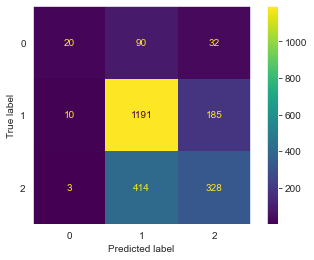

In [207]:
plot_confusion_matrix(svc, tfidf_x_ts, y_test)
plt.grid(False)

In [221]:
df_test['body'] = df_test['clean_tweet'].str.join(' ')

In [232]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_tfv = tf_vec.fit_transform(df_test.body)

df_tfv = pd.DataFrame(X_tfv.toarray(), columns=tf_vec.get_feature_names())
df_tfv.head()



,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,ability,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfv(columns)

In [242]:
df_tfv_sums = df_tfv.append(df_tfv.sum(numeric_only=True), ignore_index=True)

In [243]:
df_tfv_sums.tail()

,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,ability,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
9087,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9088,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9089,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9091,4.649007,0.705112,0.935498,3.874814,0.741375,0.4283,0.585132,2.104779,0.407726,1.51783,...,5.978721,0.852745,4.638374,2.564003,2.923855,1.06909,1.050605,1.190754,1.452015,0.380383


In [250]:
df_pos

,Tweet,Product,Emotion,Text,test,company,target
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, , awesome, ip...",ipad or iphone app,apple,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, 2, als...",ipad,apple,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,google,2
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,"[sxsw, is, just, starting, ctia, is, around, t...",android,google,2
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,"[beautifully, smart, and, simple, idea, rt, ma...",ipad or iphone app,apple,2
...,...,...,...,...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready...,iPhone,Positive emotion,"[mention, your, iphone, 4, cases, are, rad, an...",iphone,apple,2
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,"[mention, your, pr, guy, just, convinced, me, ...",iphone,apple,2
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,"[quotpapyrussort, of, like, the, ipadquot, , n...",ipad,apple,2
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,"[ive, always, used, camera, for, my, iphone, b...",ipad or iphone app,apple,2


In [248]:
df_tfv_sums.iloc[9091].sort_values(ascending=False)

store       295.261359
new         208.971155
austin      200.387100
launch      171.774050
circle      165.308805
               ...    
primo         0.221553
visto         0.221553
os            0.221553
lexpress      0.221553
nowhere       0.221553
Name: 9091, Length: 9510, dtype: float64

In [237]:
df_tfv.max().sort_values(ascending=False)[:25]

circle          1.000000
austin          1.000000
partyawesome    1.000000
rock            1.000000
take            1.000000
taken           1.000000
worship         1.000000
dev             1.000000
everywhere      1.000000
hmmmm           1.000000
screen          1.000000
line            1.000000
charging        1.000000
lazy            1.000000
traveling       1.000000
texas           1.000000
spot            1.000000
check           1.000000
haha            1.000000
doodle          1.000000
store           1.000000
heart           1.000000
watch           1.000000
location        0.971965
soo             0.954119
dtype: float64

In [235]:
df_tfv.loc[df_tfv.rock == 1]['rock']

1717    1.0
Name: rock, dtype: float64

In [244]:
df_test.Tweet.iloc[1717]

'@mention #SXSW iPad rocks'

In [249]:
df_test.iloc[1717]

Tweet             @mention #SXSW iPad rocks
Text           [mention, sxsw, ipad, rocks]
test                                   ipad
target                                    2
clean_tweet                          [rock]
body                                   rock
Name: 1718, dtype: object

In [209]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

AttributeError: 'Series' object has no attribute 'toarray'

### Models

In [ ]:
tfidf_vec = TfidfVectorizer()


In [152]:
X = df.Text
y = df.target

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [154]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [155]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [125]:
df_vec = pd.DataFrame(X_train_vec.toarray(), columns = tfidf.get_feature_names())
df_vec

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [156]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)

In [157]:
print(confusion_matrix(y_train, y_hat))

[[  18  402    8]
 [   1 4140   16]
 [   0  655 1578]]


In [158]:
print(accuracy_score(y_train, y_hat))

0.8413024347315928


In [159]:
y_hat_test = mnb.predict(X_val_vec)
print(accuracy_score(y_test, y_hat_test))

0.6559612846458425


In [160]:
from sklearn.model_selection import cross_val_score

In [161]:
cv_mnb = cross_val_score(mnb, X_train_vec, y_train, cv=5, scoring = 'accuracy')

In [162]:
cv_mnb

array([0.66202346, 0.6568915 , 0.66055718, 0.65443874, 0.65003668])

### Binary Model

In [135]:
df_binary = df

In [195]:
df_binary.drop('target', axis=1, inplace=True)
df_pos_binary = df_binary

In [194]:
binary_target_dict = {'Negative emotion' : 1, 'Positive emotion' : 0, 'Neutral emotion' : 0}
pos_binary_dict = {'Positive emotion' : 1, 'Negative emotion' : 0, 'Neutral emotion' : 0}

In [196]:
df_binary['target'] = df_binary['Emotion'].map(binary_target_dict)
df_pos_binary['target'] = df_binary['Emotion'].map(pos_binary_dict)

##### Binary model with Negative as target

In [177]:
X = df_binary.Text
y = df_binary.target

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [184]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [185]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [186]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)

In [188]:
print(confusion_matrix(y_train, y_hat))

[[6391    0]
 [ 413   14]]


In [226]:
from imblearn.over_sampling import RandomOverSampler

##### Binary model with positive as target

In [207]:
df_pos_binary['target'].value_counts()

0    6113
1    2978
Name: target, dtype: int64

In [208]:
X = df_pos_binary.Text
y = df_pos_binary.target

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [210]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [211]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [215]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)
y_test_hat = mnb.predict(X_val_vec)

In [214]:
summary_scores(mnb, X_train_vec, X_val_vec, y_train, y_test)

Training Accuracy: 0.8876503373423291
Testing Accuracy: 0.7127144742630884
F1 Score: 0.6536448564247553
Recall: 0.7127144742630884
Precision: 0.7143568554844766


In [218]:
print(confusion_matrix(y_test, y_test_hat))

[[1469   59]
 [ 594  151]]


In [175]:
from imblearn.over_sampling import SMOTE